# 02 - Clusterização: K-means e Hierárquico

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score,
    adjusted_rand_score, normalized_mutual_info_score,
    homogeneity_completeness_v_measure
)



In [54]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

In [55]:

# Configurações gerais
RANDOM_STATE = 42
N_JOBS = -1
N_SPLITS = 5  # k-fold
TEST_SIZE = 0.2

## Carregamento de dados


## Pré-processamento

### Montando o dataframe

- Carrega um arquivo JSON contendo frames de vídeo com keypoints (pontos-chave) de movimentos
- Normaliza as coordenadas usando o keypoint 0 do primeiro frame como referência
- Filtra apenas os keypoints de ID 11 a 22 (Deixa somente membros superiores, braços, mãos etc.)
    - A visibilidade a partir do keypoint 25 (dos Joelhos para baixo) é muito baixa e também não é tão importante na língua de sinais.
- Calcula estatísticas (média, desvio padrão, mínimo, máximo) para cada keypoint
- Retorna um dicionário com todas as métricas calculadas para cada keypoint
- Não considera o eixo z, pois não se provou muito efetivo em testes

In [56]:
sinais = pd.read_csv('../data/Sinais/sinais.csv')
print(sinais.shape)
print(sinais.head())

def extrair_metricas_do_arquivo(caminho_arquivo):
    """
    Extrai métricas estatísticas dos keypoints de um arquivo JSON de movimentos.
    
    Esta função processa um arquivo JSON contendo frames de vídeo com keypoints,
    normaliza as coordenadas usando o keypoint 0 do primeiro frame como referência,
    filtra apenas os keypoints de ID 11 a 22 (membros superiores) e calcula
    estatísticas para cada keypoint.
    
    Args:
        caminho_arquivo (str): Caminho para o arquivo JSON a ser processado
        
    Returns:
        dict: Dicionário contendo todas as métricas calculadas para cada keypoint
              (média, desvio padrão, mínimo e máximo para x, y e visibilidade)
              
    Raises:
        ValueError: Se o frame 0 não contiver o keypoint com ID 0
    """
    # Carregando o arquivo JSON
    sinal = pd.read_json(caminho_arquivo)
    frames = sinal['frames']
    dados_keypoints = []

    # --- Normalização: pega keypoint id=0 do frame 0 como referência ---
    ref_x, ref_y = None, None
    for keypoint in frames[0]['keypoints']:
        if keypoint['id'] == 0:
            ref_x, ref_y = keypoint['x'], keypoint['y']
            break

    if ref_x is None:
        raise ValueError("Frame 0 não contém keypoint id=0!")

    # Iterando por todos os frames
    for frame_idx, frame_data in enumerate(frames):
        for keypoint in frame_data['keypoints']:
            if 13 <= keypoint['id'] <= 22:
                dados_keypoints.append({
                    'frame': frame_idx,
                    'id': keypoint['id'],
                    # Centralização: subtrai o ponto de referência
                    'x': keypoint['x'] - ref_x,
                    'y': keypoint['y'] - ref_y,
                    'visibility': keypoint['visibility']
                })

    # Convertendo para DataFrame
    df_keypoints = pd.DataFrame(dados_keypoints)

    # Calculando métricas para cada ID e cada atributo
    metricas = df_keypoints.groupby('id').agg({
        'x': ['mean', 'std', 'min', 'max'],
        'y': ['mean', 'std', 'min', 'max'],
        'visibility': ['mean', 'std', 'min', 'max']
    })

    # Achatando colunas
    metricas.columns = ['_'.join(col).strip() for col in metricas.columns.values]
    metricas = metricas.reset_index()

    # Criando dicionário com todas as métricas
    metricas_dict = {}
    for _, row in metricas.iterrows():
        id_keypoint = int(row['id'])
        for col in metricas.columns:
            if col != 'id':
                metricas_dict[f'id_{id_keypoint}_{col}'] = row[col]

    return metricas_dict

(2502, 7)
           file_name  width  height  duration_sec  num_frames   sinal interprete
0  Adição_AP_10.json    738    1008      4.533333         136  Adição    Alexson
1   Adição_AP_1.json    774    1006      4.766667         143  Adição    Alexson
2   Adição_AP_2.json    760    1002      4.433333         133  Adição    Alexson
3   Adição_AP_3.json    762    1000      4.933333         148  Adição    Alexson
4   Adição_AP_4.json    764    1004      4.600000         138  Adição    Alexson


In [57]:
def aplicar_data_augmentation(metricas_dict, num_variantes=3, variacao_percentual=0.05):
    """
    Aplica data augmentation gerando variantes com pequenas perturbações apenas nas coordenadas x e y.
    
    Args:
        metricas_dict: Dicionário com as métricas originais
        num_variantes: Número de variantes a serem geradas
        variacao_percentual: Percentual máximo de variação a ser aplicado
        
    Returns:
        Lista de dicionários com as métricas originais e suas variantes
    """
    resultados = [metricas_dict.copy()]  # Inclui o original
    
    for i in range(num_variantes):
        variante = {}
        for chave, valor in metricas_dict.items():
            # Aplicar variação apenas em valores de x e y
            if isinstance(valor, (int, float)) and ('_x_' in chave or '_y_' in chave):
                # Calcula a variação máxima permitida
                variacao_max = abs(valor * variacao_percentual)
                # Gera um valor aleatório dentro do intervalo de variação
                perturbacao = np.random.uniform(-variacao_max, variacao_max)
                variante[chave] = valor + perturbacao
            else:
                variante[chave] = valor
        
        resultados.append(variante)
    
    return resultados

In [58]:
# --- Pipeline de extração de todos os arquivos ---
resultados = pd.DataFrame()

for idx, row in sinais.iterrows():
    caminho_arquivo = f'../data/Sinais/Sinais/{row["file_name"]}'
    try:
        metricas_arquivo = extrair_metricas_do_arquivo(caminho_arquivo)
        
        # Aplica data augmentation
        metricas_aumentadas = aplicar_data_augmentation(metricas_arquivo, num_variantes=3)
        
        for metricas in metricas_aumentadas:
            temp_df = pd.DataFrame([{**row, **metricas}])
            resultados = pd.concat([resultados, temp_df], ignore_index=True)

        if idx % 500 == 0:
            print(f"Processados {idx+1} arquivos de {len(sinais)}")

    except Exception as e:
        print(f"Erro ao processar {row['file_name']}: {e}")

Processados 1 arquivos de 2502
Erro ao processar Adição_MA_1.json: Frame 0 não contém keypoint id=0!
Processados 501 arquivos de 2502


/var/folders/ns/qqkzf_x52rqdpshm0vpl205r0000gn/T/ipykernel_8020/1803767044.py:25: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  sinal = pd.read_json(caminho_arquivo)


Erro ao processar nan: Expected object or value
Processados 1001 arquivos de 2502
Processados 1501 arquivos de 2502
Processados 2001 arquivos de 2502
Processados 2501 arquivos de 2502


# Retirando elementos com baixa visibilidade

In [59]:
# Definindo um limiar para considerar a visibilidade como baixa
limiar_visibilidade = 0.5

# Criando uma lista para armazenar as linhas com visibilidade baixa
linhas_visibilidade_baixa = []

# Identificando todas as colunas relacionadas à visibilidade
colunas_visibilidade = [col for col in resultados.columns if 'visibility' in col]

# Iterando sobre cada linha do DataFrame
for idx, row in resultados.iterrows():
    # Verificando se alguma coluna de visibilidade média está abaixo do limiar
    colunas_visibilidade_media = [col for col in colunas_visibilidade if 'visibility_mean' in col]
    
    # Se alguma coluna de visibilidade média estiver abaixo do limiar, adiciona à lista
    if any(row[col] < limiar_visibilidade for col in colunas_visibilidade_media):
        linhas_visibilidade_baixa.append(idx)

# Exibindo as linhas com visibilidade baixa
print(f"Foram encontradas {len(linhas_visibilidade_baixa)} linhas com visibilidade média abaixo de {limiar_visibilidade}")

# Selecionando apenas as colunas de visibilidade e informações básicas
colunas_para_exibir = ['file_name', 'sinal', 'interprete'] + colunas_visibilidade

# Exibindo todas as linhas com visibilidade baixa, mas apenas as colunas relacionadas à visibilidade
print("\nLinhas com visibilidade baixa (apenas colunas de visibilidade):")

# Verificando quais sinais têm mais problemas de visibilidade
sinais_problematicos = resultados.iloc[linhas_visibilidade_baixa]['sinal'].value_counts()

# Removendo as linhas com visibilidade baixa do DataFrame
resultados = resultados.drop(linhas_visibilidade_baixa)
print(f"\nDataFrame após remover linhas com visibilidade baixa: {resultados.shape}")

Foram encontradas 40 linhas com visibilidade média abaixo de 0.5

Linhas com visibilidade baixa (apenas colunas de visibilidade):

DataFrame após remover linhas com visibilidade baixa: (9960, 127)


# Remoção de colunas

Vou remover as colunas que nao vão ajudar na classificação

In [60]:
# Identificando todas as colunas relacionadas à visibilidade
colunas_visibilidade = [col for col in resultados.columns if 'visibility' in col]

# Exibindo as colunas que serão removidas
print(f"Removendo {len(colunas_visibilidade)} colunas relacionadas à visibilidade:")
print(colunas_visibilidade)

# Removendo as colunas de visibilidade do DataFrame
resultados = resultados.drop(columns=colunas_visibilidade)
print(f"\nDimensões do DataFrame após remover colunas de visibilidade: {resultados.shape}")

# Removendo colunas que não são relevantes para a classificação
colunas_para_remover = ['file_name', 'duration_sec', 'num_frames', 'width', 'height']
resultados = resultados.drop(columns=colunas_para_remover)
print(f"Dimensões do DataFrame após remover colunas irrelevantes: {resultados.shape}")


Removendo 40 colunas relacionadas à visibilidade:
['id_13_visibility_mean', 'id_13_visibility_std', 'id_13_visibility_min', 'id_13_visibility_max', 'id_14_visibility_mean', 'id_14_visibility_std', 'id_14_visibility_min', 'id_14_visibility_max', 'id_15_visibility_mean', 'id_15_visibility_std', 'id_15_visibility_min', 'id_15_visibility_max', 'id_16_visibility_mean', 'id_16_visibility_std', 'id_16_visibility_min', 'id_16_visibility_max', 'id_17_visibility_mean', 'id_17_visibility_std', 'id_17_visibility_min', 'id_17_visibility_max', 'id_18_visibility_mean', 'id_18_visibility_std', 'id_18_visibility_min', 'id_18_visibility_max', 'id_19_visibility_mean', 'id_19_visibility_std', 'id_19_visibility_min', 'id_19_visibility_max', 'id_20_visibility_mean', 'id_20_visibility_std', 'id_20_visibility_min', 'id_20_visibility_max', 'id_21_visibility_mean', 'id_21_visibility_std', 'id_21_visibility_min', 'id_21_visibility_max', 'id_22_visibility_mean', 'id_22_visibility_std', 'id_22_visibility_min', 'id

In [61]:
resultados.head()

,sinal,interprete,id_13_x_mean,id_13_x_std,id_13_x_min,id_13_x_max,id_13_y_mean,id_13_y_std,id_13_y_min,id_13_y_max,id_14_x_mean,id_14_x_std,id_14_x_min,id_14_x_max,id_14_y_mean,id_14_y_std,id_14_y_min,id_14_y_max,id_15_x_mean,id_15_x_std,id_15_x_min,id_15_x_max,id_15_y_mean,id_15_y_std,id_15_y_min,id_15_y_max,id_16_x_mean,id_16_x_std,id_16_x_min,id_16_x_max,id_16_y_mean,id_16_y_std,id_16_y_min,id_16_y_max,id_17_x_mean,id_17_x_std,id_17_x_min,id_17_x_max,id_17_y_mean,id_17_y_std,id_17_y_min,id_17_y_max,id_18_x_mean,id_18_x_std,id_18_x_min,id_18_x_max,id_18_y_mean,id_18_y_std,id_18_y_min,id_18_y_max,id_19_x_mean,id_19_x_std,id_19_x_min,id_19_x_max,id_19_y_mean,id_19_y_std,id_19_y_min,id_19_y_max,id_20_x_mean,id_20_x_std,id_20_x_min,id_20_x_max,id_20_y_mean,id_20_y_std,id_20_y_min,id_20_y_max,id_21_x_mean,id_21_x_std,id_21_x_min,id_21_x_max,id_21_y_mean,id_21_y_std,id_21_y_min,id_21_y_max,id_22_x_mean,id_22_x_std,id_22_x_min,id_22_x_max,id_22_y_mean,id_22_y_std,id_22_y_min,id_22_y_max
0,Adição,Alexson,239.051471,20.950142,199.000000,261.000000,460.316176,5.452423,454.000000,472.000000,-271.669118,65.398387,-369.000000,-213.000000,406.279412,63.158905,298.000000,461.000000,64.242647,37.984109,7.000000,98.000000,505.735294,137.498134,272.000000,619.000000,-116.463235,64.089163,-226.000000,-57.000000,454.566176,188.854547,165.000000,624.000000,16.102941,41.610234,-48.000000,53.000000,539.911765,187.441664,224.000000,689.000000,-66.514706,58.612347,-169.000000,-11.000000,491.823529,227.956100,140.000000,692.000000,4.889706,32.517727,-48.000000,37.000000,508.985294,186.493252,197.000000,658.000000,-39.477941,58.173937,-139.000000,16.000000,465.352941,215.872168,133.000000,656.000000,16.073529,31.556799,-34.000000,46.000000,492.933824,168.908838,211.000000,631.000000,-47.250000,57.658991,-146.000000,9.000000,456.227941,201.162583,149.000000,635.000000
1,Adição,Alexson,244.170265,20.212549,195.266385,270.733620,454.997630,5.532154,476.121379,467.292601,-259.667106,63.107089,-351.996646,-210.014440,388.845225,64.136961,288.392125,449.791024,61.224181,39.085325,6.786377,100.211092,519.716668,143.091764,277.915117,588.057388,-113.034925,64.782031,-218.005334,-59.776083,458.316217,189.745249,170.415481,643.663129,16.751322,42.342411,-49.440905,51.923198,536.871359,196.652569,216.985050,695.760938,-68.066667,57.987901,-168.199584,-10.700213,510.247739,225.248385,140.269666,677.484755,5.132562,31.267040,-50.243637,36.188467,515.598504,181.558986,200.940226,633.984525,-40.433686,59.818903,-141.872817,16.292632,459.065557,217.324124,127.718265,681.717664,16.190708,31.941862,-34.523943,46.273787,487.698952,172.643290,219.138446,624.066062,-49.471940,56.916017,-145.019462,8.928400,437.429144,196.864916,147.642891,625.772658
2,Adição,Alexson,248.294526,20.861905,204.037584,254.101301,473.175618,5.423475,463.898499,485.927651,-275.317599,67.657724,-373.776437,-215.270657,418.402414,63.407626,289.891710,450.471043,62.539696,38.388789,7.115250,96.455200,511.095587,141.524759,265.224658,647.167681,-120.695914,63.282296,-233.304339,-59.282954,439.599776,180.843145,161.057167,600.784655,16.333886,40.991290,-49.604156,55.614137,520.211350,194.027461,234.272139,678.874042,-69.244994,56.094477,-171.140696,-11.203243,504.513879,218.940561,139.404941,708.560438,5.095112,31.312126,-48.932732,37.681390,516.122601,181.359060,195.499413,645.703953,-38.309646,59.009414,-132.509028,15.204058,447.503125,210.400837,128.013124,656.766622,16.552644,32.094789,-33.283421,45.104227,516.623240,172.381186,201.375289,662.187281,-49.135920,58.945444,-145.142346,8.989630,436.759372,200.827933,141.704171,609.390522
3,Adição,Alexson,240.769074,21.035915,201.475656,255.193167,453.585823,5.648614,474.807860,467.684826,-263.653063,64.628228,-368.077073,-212.372780,399.729765,64.182862,293.743038,457.541008,67.021588,36.270398,6.847687,96.861402,495.020871,139.204485,283.109136,599.834735,-117.079661,62.510760,-219.970235,-54.865203,441.295180,192.450890,160.452554,602.715814,15.7

In [62]:
resultados.shape

(9960, 82)

## helpers e preparação do X (sem rótulo)

In [63]:
# Métrica própria: Purity
def cluster_purity(y_true, y_pred):
    # y_true/pred como inteiros 0..C-1
    df = pd.DataFrame({'t': y_true, 'c': y_pred})
    return df.groupby('c')['t'].apply(lambda s: s.value_counts().max()).sum() / len(df)

# Pequena heurística para "cotovelo" (knee) na curva de inércia
def guess_k_from_elbow(ks, inertias):
    ks = np.array(ks)
    y = np.array(inertias, dtype=float)
    # normaliza 0-1
    y = (y - y.min()) / (y.max() - y.min() + 1e-9)
    # seg. derivada discreta
    curv = np.gradient(np.gradient(y))
    k_idx = np.argmin(curv)  # ponto com maior "curvatura"
    return int(ks[k_idx])

# Plot genérico (cores por classe)
def plot_proj(Z, y_num, names, title, xlab="Comp. 1", ylab="Comp. 2"):
    cmap = plt.cm.rainbow if len(names) > 20 else plt.cm.tab20
    norm = plt.Normalize(vmin=min(y_num), vmax=max(y_num))
    plt.figure(figsize=(8, 6))
    plt.scatter(Z[:, 0], Z[:, 1], c=y_num, cmap=cmap, s=20, alpha=0.75)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    handles = [
        plt.Line2D([0],[0], marker='o', linestyle='',
                   markerfacecolor=cmap(norm(k)), markeredgecolor='none',
                   markersize=6, label=cls)
        for k, cls in enumerate(names)
    ]
    plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
    plt.tight_layout()
    plt.show()

# Plot clusters (cores por cluster, não por classe)
def plot_clusters(Z, y_clusters, title, xlab="Comp. 1", ylab="Comp. 2"):
    plt.figure(figsize=(8, 6))
    plt.scatter(Z[:, 0], Z[:, 1], c=y_clusters, s=20, alpha=0.75)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.tight_layout()
    plt.show()

# --- A.1) Monta X sem rótulo (remove 'sinal') e escala ---
assert 'sinal' in resultados.columns and 'interprete' in resultados.columns

cols_drop = [c for c in ['sinal','interprete','file_name'] if c in resultados.columns]
X_plot = resultados.drop(columns=cols_drop, errors='ignore')\
                  .select_dtypes(include=[np.number]).copy()

prep = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
X_scaled = prep.fit_transform(X_plot)

# Guardamos rótulos verdadeiros apenas para visualização/avaliação (não entram no treino de clusters)
labels_str = resultados['sinal'].to_numpy()
le = LabelEncoder().fit(labels_str)
y_true = le.transform(labels_str)          # 0..C-1
class_names = le.classes_
print("X_scaled shape:", X_scaled.shape, "| nº classes:", len(class_names))


X_scaled shape: (9960, 80) | nº classes: 25


## Projeções 2D: PCA, t-SNE, UMAP

/Users/felipelima/ml-projeto/venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 2000 with accuracies 
[3.15635450e-15 9.87244027e-07 1.14697019e-06 3.76095027e-05]
not reaching the requested tolerance 1.773238182067871e-06.
Use iteration 711 instead with accuracy 
2.5943291876164473e-06.

  _, diffusion_map = lobpcg(
/Users/felipelima/ml-projeto/venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[1.51143480e-15 1.64270333e-06 1.22256970e-06 7.51204372e-06]
not reaching the requested tolerance 1.773238182067871e-06.
  _, diffusion_map = lobpcg(


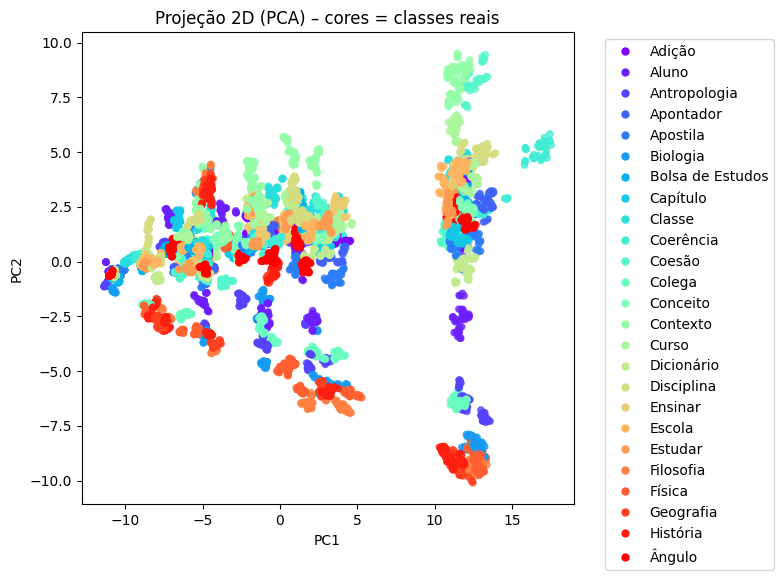

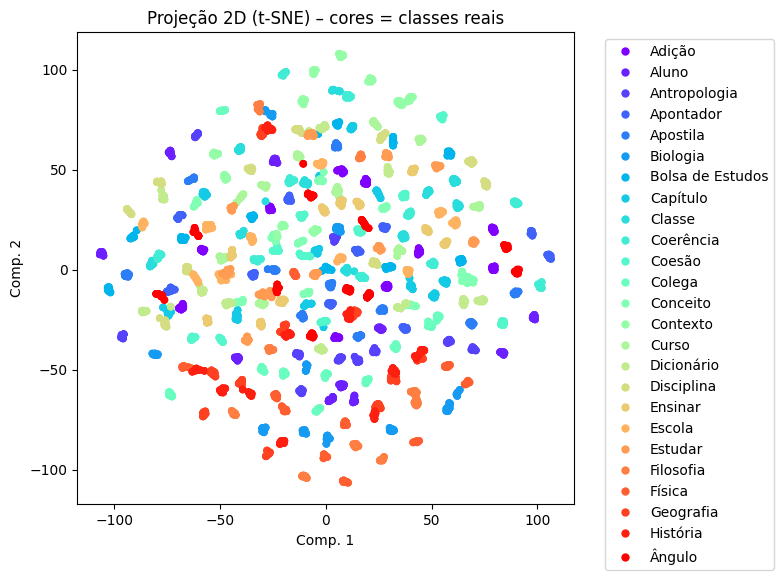

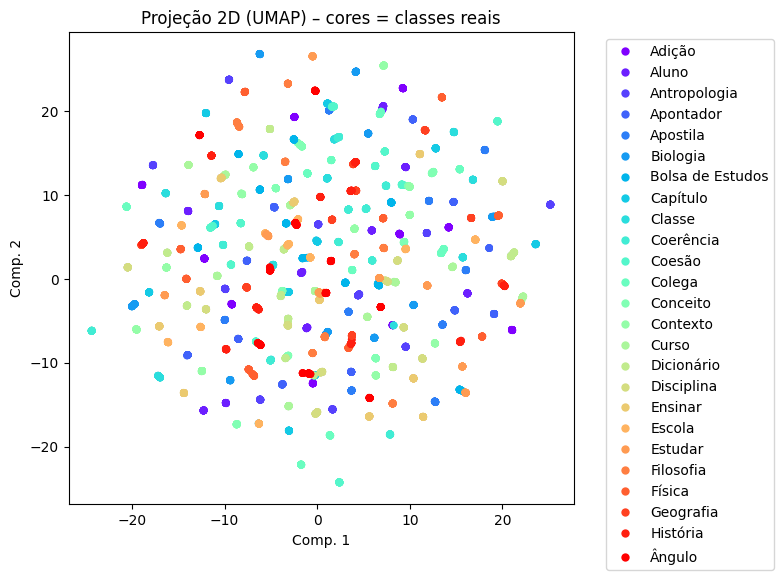

In [64]:
# --- B) Gera projeções PCA / t-SNE / UMAP ---
Z_pca = PCA(n_components=2, random_state=42).fit_transform(X_scaled)

Z_tsne = TSNE(
    n_components=2, perplexity=30, learning_rate='auto',
    init='pca', max_iter=1000, random_state=42
).fit_transform(X_scaled)

try:
    import umap
    Z_umap = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=42)\
                 .fit_transform(X_scaled)
    HAS_UMAP = True
except Exception as e:
    print("UMAP não disponível:", e)
    Z_umap = None
    HAS_UMAP = False

# Visualizações coloridas pelos rótulos reais (apenas referência visual)
plot_proj(Z_pca,  y_true, class_names, "Projeção 2D (PCA) – cores = classes reais", "PC1", "PC2")
plot_proj(Z_tsne, y_true, class_names, "Projeção 2D (t-SNE) – cores = classes reais")
if HAS_UMAP:
    plot_proj(Z_umap, y_true, class_names, "Projeção 2D (UMAP) – cores = classes reais")


## Cotovelo do K-means (escolha de K)

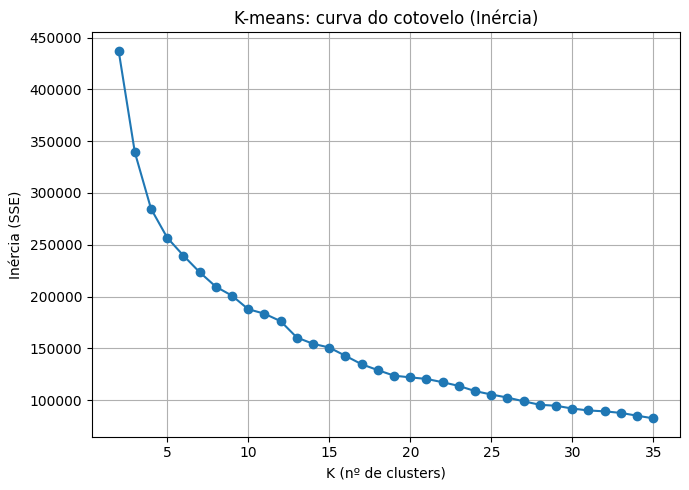

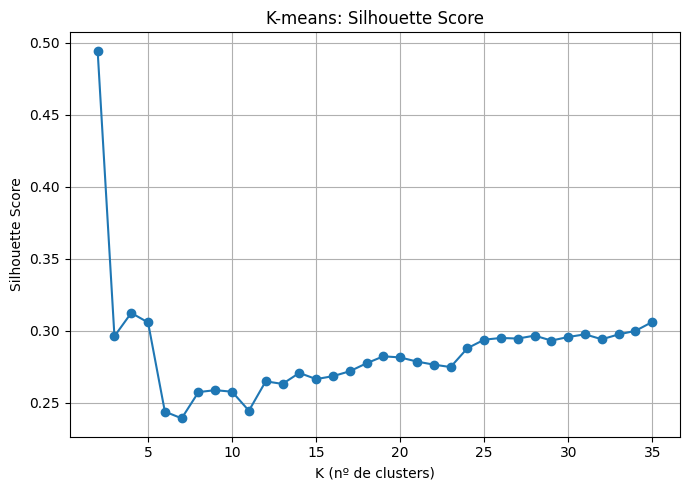

K sugerido pela heurística do cotovelo: 12


In [65]:
# --- C) Curva do cotovelo para K-means ---
ks = list(range(2, 36))  # ajuste se quiser
inertias = []
silhouette_scores = []

for k in ks:
    km = KMeans(n_clusters=k, n_init='auto', random_state=42)
    y_pred = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    
    # Calcula o silhouette score (apenas para k >= 2)
    if k > 1:
        silhouette_scores.append(silhouette_score(X_scaled, y_pred))
    else:
        silhouette_scores.append(0)  # Para k=1 não é possível calcular

# Plot da inércia (cotovelo)
plt.figure(figsize=(7,5))
plt.plot(ks, inertias, marker='o')
plt.title("K-means: curva do cotovelo (Inércia)")
plt.xlabel("K (nº de clusters)"); plt.ylabel("Inércia (SSE)")
plt.grid(True); plt.tight_layout(); plt.show()

# Plot do silhouette score
plt.figure(figsize=(7,5))
plt.plot(ks, silhouette_scores, marker='o')
plt.title("K-means: Silhouette Score")
plt.xlabel("K (nº de clusters)"); plt.ylabel("Silhouette Score")
plt.grid(True); plt.tight_layout(); plt.show()

k_elbow = guess_k_from_elbow(ks, inertias)
print("K sugerido pela heurística do cotovelo:", k_elbow)
# Se desejar fixar manualmente (ex.: 25), descomente:
# k_elbow = 25


## K-means com K do cotovelo + plots

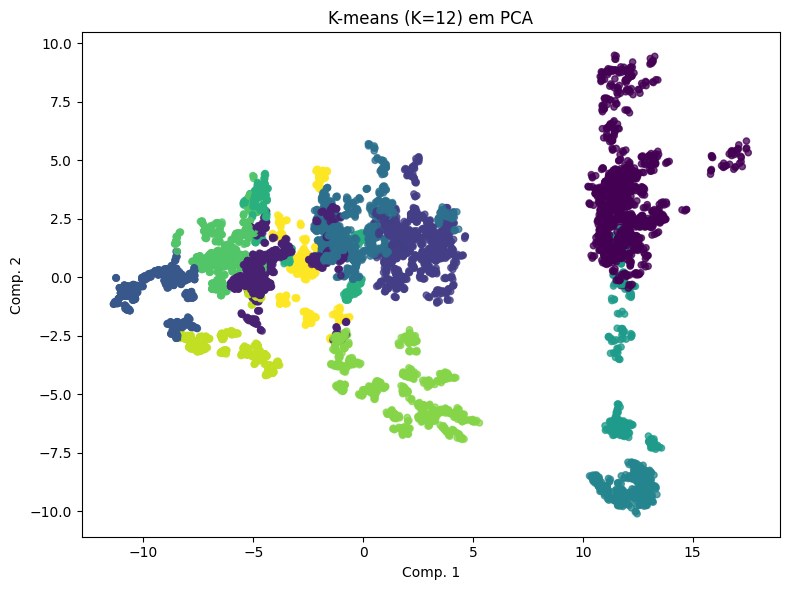

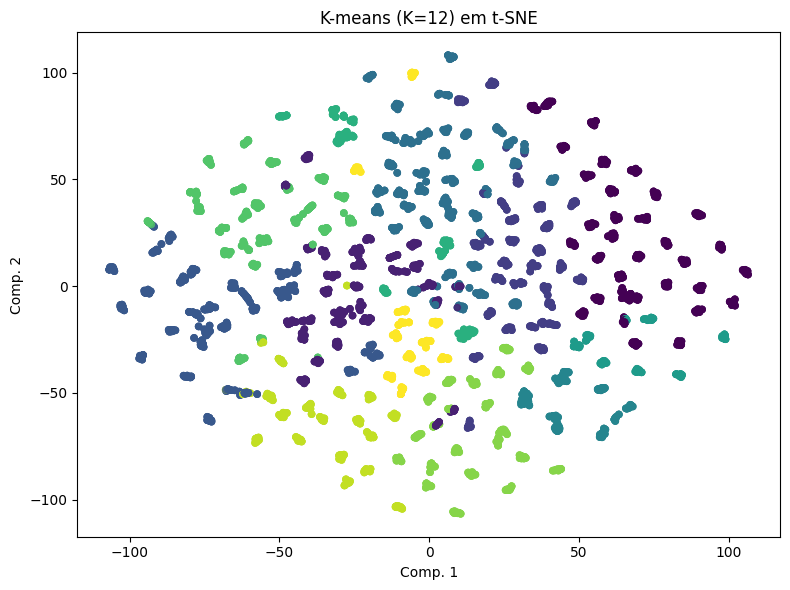

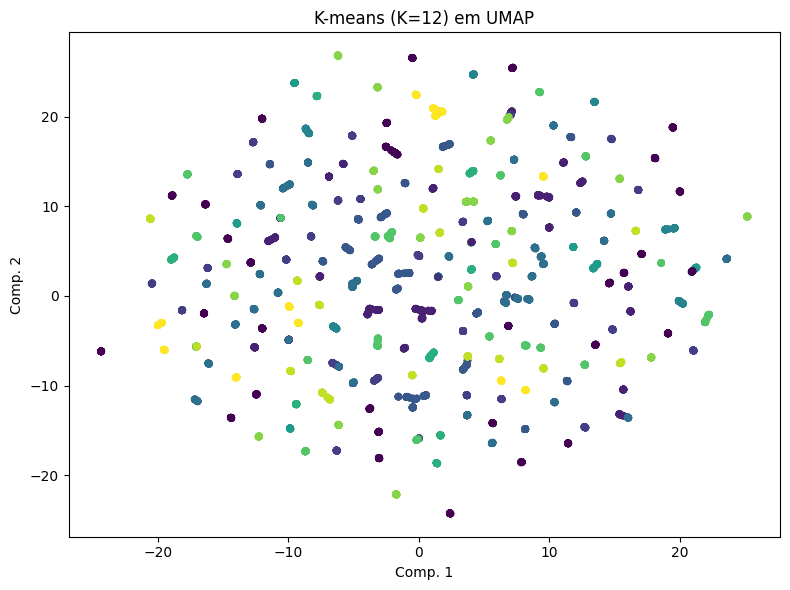

In [66]:
# --- D) K-means final com K do cotovelo ---
K = k_elbow
kmeans = KMeans(n_clusters=K, n_init='auto', random_state=42)
y_km = kmeans.fit_predict(X_scaled)

# Plots por cluster nas projeções
plot_clusters(Z_pca,  y_km, f"K-means (K={K}) em PCA")
plot_clusters(Z_tsne, y_km, f"K-means (K={K}) em t-SNE")
if HAS_UMAP:
    plot_clusters(Z_umap, y_km, f"K-means (K={K}) em UMAP")


## Hierárquico (2 linkages) com o mesmo K + plots

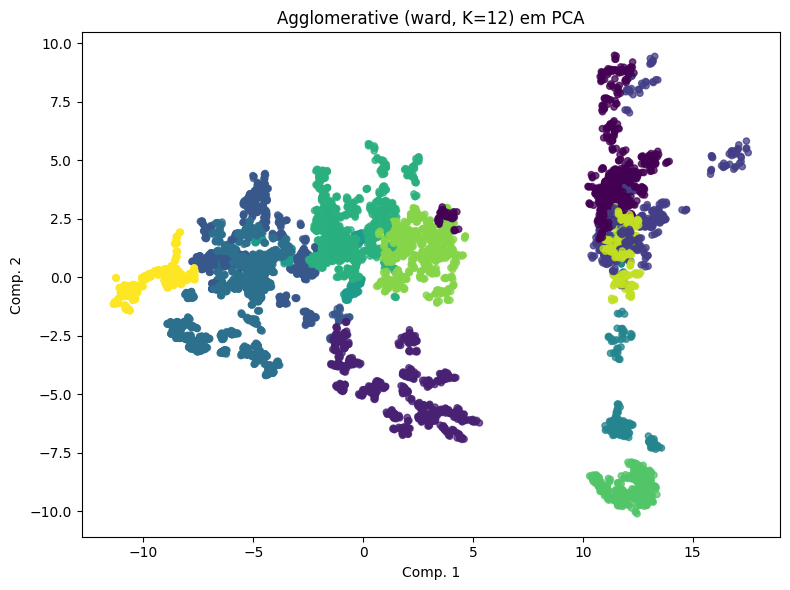

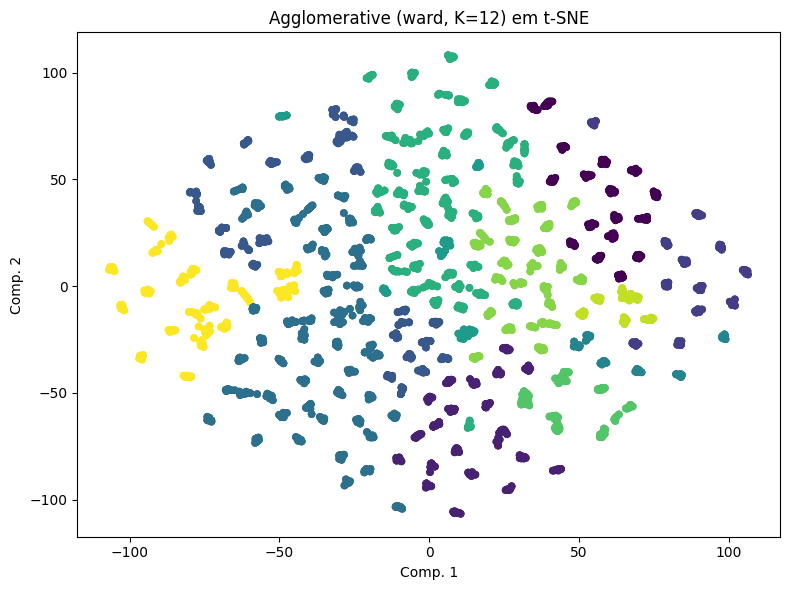

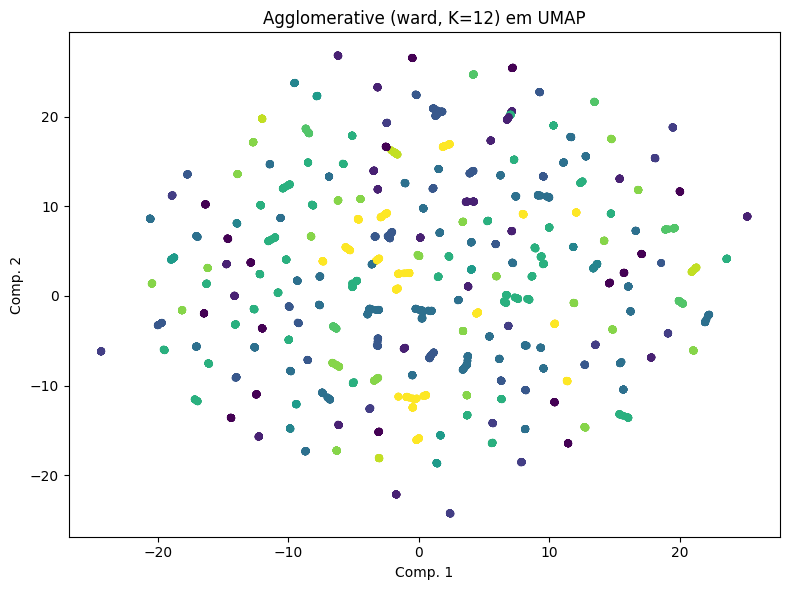

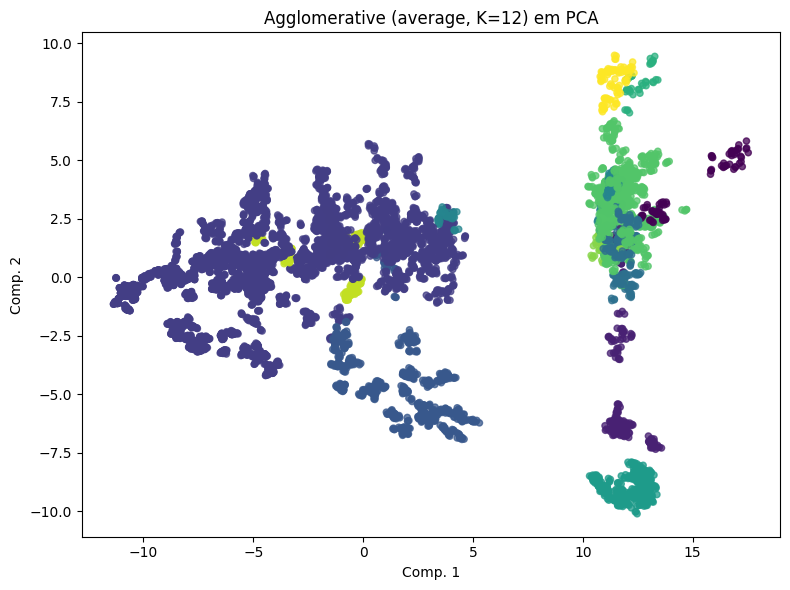

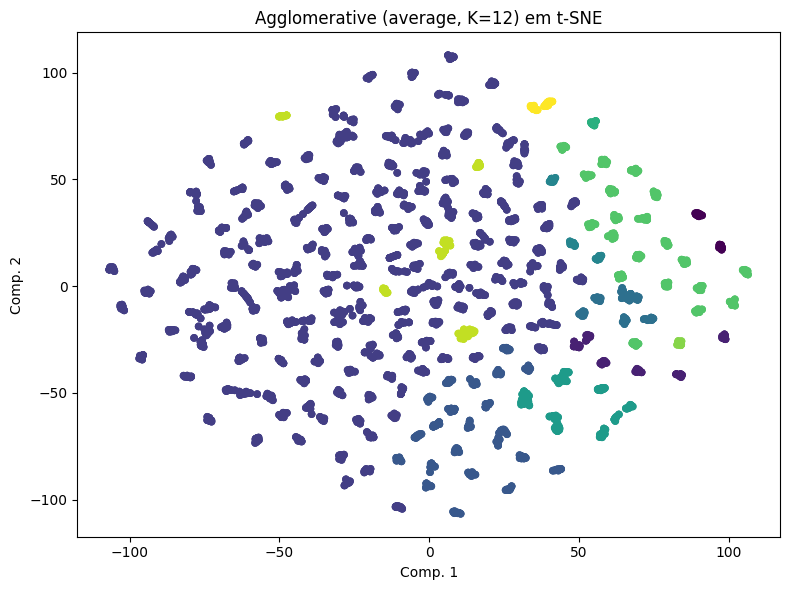

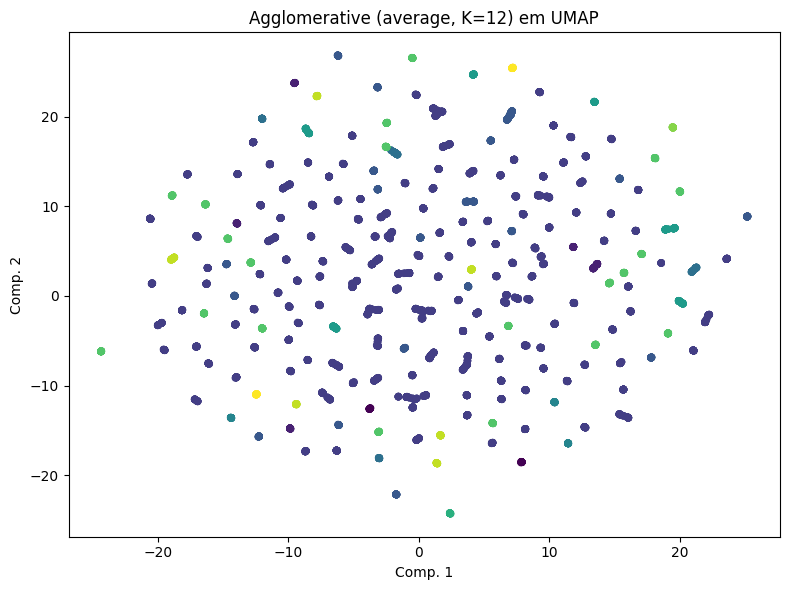

In [67]:
# --- E) Hierárquico (mesmo K) com 2 linkages ---
# Ward (só euclidiano) e Average (euclidiano)
agg_ward   = AgglomerativeClustering(n_clusters=K, linkage='ward', metric='euclidean')
agg_avg    = AgglomerativeClustering(n_clusters=K, linkage='average', metric='euclidean')

y_ag_ward = agg_ward.fit_predict(X_scaled)
y_ag_avg  = agg_avg.fit_predict(X_scaled)

# Plots
plot_clusters(Z_pca,  y_ag_ward, f"Agglomerative (ward, K={K}) em PCA")
plot_clusters(Z_tsne, y_ag_ward, f"Agglomerative (ward, K={K}) em t-SNE")
if HAS_UMAP:
    plot_clusters(Z_umap, y_ag_ward, f"Agglomerative (ward, K={K}) em UMAP")

plot_clusters(Z_pca,  y_ag_avg, f"Agglomerative (average, K={K}) em PCA")
plot_clusters(Z_tsne, y_ag_avg, f"Agglomerative (average, K={K}) em t-SNE")
if HAS_UMAP:
    plot_clusters(Z_umap, y_ag_avg, f"Agglomerative (average, K={K}) em UMAP")


## Avaliação: interna, externa e Purity (métrica própria) + comparação

In [68]:
# --- F) Avaliações ---
def eval_all(X, y_pred, y_true):
    # internas (só X e y_pred)
    sil = silhouette_score(X, y_pred, metric='euclidean')
    ch  = calinski_harabasz_score(X, y_pred)
    db  = davies_bouldin_score(X, y_pred)
    # externas (comparam com verdade-terra, só para análise)
    ari = adjusted_rand_score(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)
    h, c, v = homogeneity_completeness_v_measure(y_true, y_pred)
    pur = cluster_purity(y_true, y_pred)
    return dict(silhouette=sil, calinski=ch, davies=db, ARI=ari, NMI=nmi, homogeneity=h, completeness=c, v_measure=v, purity=pur)

res = {
    f'KMeans(K={K})': eval_all(X_scaled, y_km, y_true),
    f'Agg-Ward(K={K})': eval_all(X_scaled, y_ag_ward, y_true),
    f'Agg-Average(K={K})': eval_all(X_scaled, y_ag_avg, y_true),
}

pd.DataFrame(res).T.sort_values('silhouette', ascending=False)


,silhouette,calinski,davies,ARI,NMI,homogeneity,completeness,v_measure,purity
Agg-Average(K=12),0.265478,1772.591563,1.020413,0.014319,0.231820,0.161432,0.411044,0.231820,0.116466
KMeans(K=12),0.264742,3185.418006,1.289697,0.059087,0.241260,0.210030,0.283400,0.241260,0.131526
Agg-Ward(K=12),0.238122,3332.923958,1.435880,0.054421,0.251641,0.214231,0.304881,0.251641,0.132932
